## Random Forests Bootstrapping

1727
Distribution of safety ratings in 1727 of data:
safety
med     0.333526
high    0.333526
low     0.332947
Name: proportion, dtype: float64
Distribution of safety ratings in bootstrapped sample data:
safety
med     0.338738
high    0.332947
low     0.328315
Name: proportion, dtype: float64
0.3329334105385061


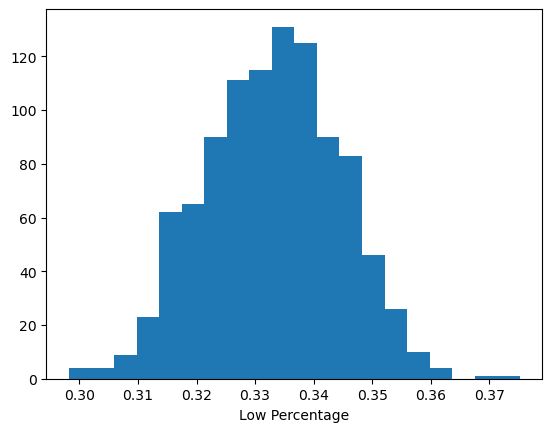

Average low percentage: 0.3329
95% Confidence Interval for low percengage: (0.3115,0.3538)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Models from scikit learn module:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df = pd.read_csv('data/car_evaluation.csv')

#df['accep'] = ~(df['accep']=='unacc') #1 is acceptable, 0 if not acceptable
df['accep'] = ~(df.iloc[:, 6]=='unacc')
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)
y = df['accep']

x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.25)
nrows = df.shape[0]

df['safety'] = df.iloc[:, 5]

## 1. Print number of rows and distribution of safety ratings
print(nrows)
print(f'Distribution of safety ratings in {nrows} of data:')
print(df.safety.value_counts(normalize=True))

## 2. Create bootstrapped sample
boot_sample = df.sample(nrows, replace=True)
print(f'Distribution of safety ratings in bootstrapped sample data:')
print(boot_sample.safety.value_counts(normalize=True))


## 3. Create 1000 bootstrapped samples
low_perc = []
for i in range(1000):
    boot_sample = df.sample(nrows, replace=True)
    low_perc.append(boot_sample.safety.value_counts(normalize=True)['low'])

## 4. Plot a histogram of the low percentage values
mean_lp = np.mean(low_perc) 
print(mean_lp)
plt.hist(low_perc, bins=20);
plt.xlabel('Low Percentage')
plt.show()

## 5. What are the 2.5 and 97.5 percentiles?
print(f'Average low percentage: {np.mean(low_perc).round(4)}')

low_perc.sort()
print(f'95% Confidence Interval for low percengage: ({low_perc[25].round(4)},{low_perc[975].round(4)})')

### Bagging

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score


df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df['accep'] = ~(df['accep']=='unacc') #1 is acceptable, 0 if not acceptable
#df = pd.read_csv('data/car_evaluation.csv')
#df['accep'] = ~(df.iloc[:, 6]=='unacc')

X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)
y = df['accep']
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.25)

#original decision tree trained on full training set
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(x_train, y_train)
#print(f'Accuracy score of DT on test set (trained using full set): {dt.score(x_test, y_test).round(4)}')
print(f'Accuracy score of DT on test set (trained using full set): {round(dt.score(x_test, y_test), 4)}')


#2. New decision tree trained on bootstrapped sample
dt2 = DecisionTreeClassifier(max_depth=5)
#ids are the indices of the bootstrapped sample
ids = x_train.sample(x_train.shape[0], replace=True, random_state=0).index
dt2.fit(x_train.loc[ids], y_train[ids])#max_depth=50,criterion='gini')
print(f'Accuracy score of DT on test set (trained using bootstrapped sample): {round(dt2.score(x_test, y_test), 4)}')

## 3. Bootstapping ten samples and aggregating the results:
preds = []
random_state = 0
for i in range(10):
    ids = x_train.sample(x_train.shape[0], replace=True, random_state=random_state+i).index
    dt2.fit(x_train.loc[ids], y_train[ids])
    preds.append(dt2.predict(x_test))   
ba_pred = np.array(preds).mean(0)

# 4. Calculate accuracy of the bagged sample
ba_accuracy = accuracy_score(ba_pred>=0.5, y_test)
print(f'Accuracy score of aggregated 10 bootstrapped samples:{round(ba_accuracy, 4)}')

Accuracy score of DT on test set (trained using full set): 0.8588
Accuracy score of DT on test set (trained using bootstrapped sample): 0.8912
Accuracy score of aggregated 10 bootstrapped samples:0.9097


### Random feature selection

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df['accep'] = ~(df['accep']=='unacc') #1 is acceptable, 0 if not acceptable
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)
y = df['accep']
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.25)
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
print("Accuracy score of DT on test set (trained using full feature set):")
accuracy_dt = dt.score(x_test, y_test)
print(accuracy_dt)

# 1. Create rand_features, random samples from the set of features
rand_features = np.random.choice(x_train.columns,10)

# Make new decision tree trained on random sample of 10 features and calculate the new accuracy score
dt2 = DecisionTreeClassifier()

dt2.fit(x_train[rand_features], y_train)
print("Accuracy score of DT on test set (trained using random feature sample):")
accuracy_dt2 = dt2.score(x_test[rand_features], y_test)
print(accuracy_dt2)

# 2. Build decision trees on 10 different random samples 
predictions = []
for i in range(10):
    rand_features = np.random.choice(x_train.columns,10)
    dt2.fit(x_train[rand_features], y_train)
    predictions.append(dt2.predict(x_test[rand_features]))

## 3. Get aggregate predictions and accuracy score
prob_predictions = np.array(predictions).mean(0)
agg_predictions = (prob_predictions>0.5)
agg_accuracy = accuracy_score(agg_predictions, y_test)
print('Accuracy score of aggregated 10 samples:')
print(agg_accuracy)


Accuracy score of DT on test set (trained using full feature set):
0.9444444444444444
Accuracy score of DT on test set (trained using random feature sample):
0.9027777777777778
Accuracy score of aggregated 10 samples:
0.7384259259259259


### Bagging in Scikit-Learn

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df['accep'] = ~(df['accep']=='unacc') #1 is acceptable, 0 if not acceptable
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)
y = df['accep']
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.25)

# 1. Bagging classifier with 10 Decision Tree base estimators
bag_dt = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10)
bag_dt.fit(x_train, y_train)

print('Accuracy score of Bagged Classifier, 10 estimators:')
bag_accuracy = bag_dt.score(x_test, y_test)
print(bag_accuracy)

# 2.Set `max_features` to 10.
bag_dt_10 = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10, max_features=10)
bag_dt_10.fit(x_train, y_train)

print('Accuracy score of Bagged Classifier, 10 estimators, 10 max features:')
bag_accuracy_10 = bag_dt_10.score(x_test, y_test)
print(bag_accuracy_10)


# 3. Change base estimator to Logistic Regression
from sklearn.linear_model import LogisticRegression
bag_lr = BaggingClassifier(estimator=LogisticRegression(),
                         n_estimators=10, max_features=10)
bag_lr.fit(x_train, y_train)

print('Accuracy score of Logistic Regression, 10 estimators:')
bag_accuracy_lr = bag_lr.score(x_test, y_test)
print(bag_accuracy_lr)


Accuracy score of Bagged Classifier, 10 estimators:
0.9027777777777778
Accuracy score of Bagged Classifier, 10 estimators, 10 max features:
0.8981481481481481
Accuracy score of Logistic Regression, 10 estimators:
0.8912037037037037


### Train and Predict using `scikit-learn`

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df['accep'] = ~(df['accep']=='unacc') #1 is acceptable, 0 if not acceptable
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)
y = df['accep']
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.25)

# 1. Create a Random Forest Classifier and print its parameters
rf = RandomForestClassifier()
print('Random Forest parameters:')
rf_params = rf.get_params()
print(rf_params)

# 2. Fit the Random Forest Classifier to training data and calculate accuracy score on the test data
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print('Test set accuracy:')
rf_accuracy = rf.score(x_test, y_test)
print(rf_accuracy)

# 3. Calculate Precision and Recall scores and the Confusion Matrix
rf_precision = precision_score(y_test, y_pred)
print(f'Test set precision: {rf_precision}')
rf_recall = recall_score(y_test, y_pred)
print(f'Test set recall: {rf_recall}')
rf_confusion_matrix = confusion_matrix(y_test, y_pred)
print(f'Test set confusion matrix:\n{rf_confusion_matrix}')


Random Forest parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Test set accuracy:
0.9490740740740741
Test set precision: 0.9384615384615385
Test set recall: 0.8970588235294118
Test set confusion matrix:
[[288   8]
 [ 14 122]]


### Random Forest Regressor

In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df['accep'] = ~(df['accep']=='unacc') #1 is acceptable, 0 if not acceptable
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)

## Generating some fake prices for regression! :) 
fake_prices = (15000 + 25*df.index.values)+np.random.normal(size=df.shape[0])*5000
df['price'] = fake_prices
print(df.price.describe())
y = df['price']

x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.25)

# 1. Create a Random Regressor and print `R^2` scores on training and test data
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)

r_squared_train = rfr.score(x_train, y_train)
print(f'Train set R^2: {r_squared_train}')

r_squared_test = rfr.score(x_test, y_test)
print(f'Test set R^2: {r_squared_test}')

# 2. Print Mean Absolute Error on training and test data

avg_price = y.mean()
print(f'Avg Price Train/Test: {avg_price}')

y_pred_train =rfr.predict(x_train)
y_pred_test =rfr.predict(x_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
print(f'Train set MAE: {mae_train}')

mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Test set MAE: {mae_test}')



count     1728.000000
mean     36710.488990
std      13292.159198
min       5174.902339
25%      25717.386389
50%      37101.325269
75%      47567.872101
max      68309.310911
Name: price, dtype: float64
Train set R^2: 0.9756322260254321
Test set R^2: 0.8349362918957832
Avg Price Train/Test: 36710.488990304766
Train set MAE: 1622.8212125332702
Test set MAE: 4348.138853315431
